In [1]:
import pandas as pd
import numpy as np
import os
# import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display


In [2]:
import os,glob,pickle

In [3]:
def get_features(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc


In [4]:

def load_data(test_size=0.2):
    x=[]
    y=[]
    for file in glob.glob(r"C:\Users\Saurabh\ml\btp\data\*"):
        basename = os.path.basename(file)
        label = file.split('_')[-1]
        label = label.split('.')[0]
        
        for f in glob.glob(file+"\*"):
            y.append(label.lower())
            x.append(get_features(f))
    return x,y

In [5]:
x,y=load_data()

In [6]:
x=np.array(x)
# y=y.toarray()

In [7]:
print(x.shape)

(2792, 40)


In [8]:
a=[]
b=[]

In [9]:
a=x
b=y

In [10]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
enc = LabelEncoder()
enc.fit(y)
nf=enc.transform(y)

In [11]:
print(nf)

[0 0 0 ... 5 5 5]


In [12]:
ncf = nf.reshape(-1, 1) 
ohe = OneHotEncoder(sparse=False)
ncf= ohe.fit_transform(ncf)


In [13]:
y=ncf

In [14]:
x= np.expand_dims(x, -1)
x.shape

(2792, 40, 1)

In [16]:
# md = model.fit(x, y, validation_split=0.2, epochs=10, batch_size=64)

In [17]:
x.shape

(2792, 40, 1)

In [18]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(np.array(x),y,test_size=0.2,random_state=0)

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.regularizers import l2
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
# from keras.utils import to_categorical
from keras.layers import Activation, Dense
from keras.layers import Input, Flatten, Dropout, Activation
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(40,1)))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 256)           1536      
                                                                 
 dropout (Dropout)           (None, 40, 256)           0         
                                                                 
 activation (Activation)     (None, 40, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 128)           163968    
                                                                 
 dropout_1 (Dropout)         (None, 40, 128)           0         
                                                                 
 activation_1 (Activation)   (None, 40, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 128)           0

C:\Users\Saurabh\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [20]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['acc',f1_m,precision_m, recall_m])

In [39]:
history=model.fit(x_train, y_train,validation_data=(x_test,y_test), batch_size=16, epochs=30)

Epoch 1/30
140/140 [==============================] - 2s 13ms/step - loss: 0.1894 - acc: 0.9328 - f1_m: 0.9346 - precision_m: 0.9453 - recall_m: 0.9248 - val_loss: 0.1612 - val_acc: 0.9463 - val_f1_m: 0.9467 - val_precision_m: 0.9567 - val_recall_m: 0.9375
Epoch 2/30
140/140 [==============================] - 2s 12ms/step - loss: 0.1736 - acc: 0.9436 - f1_m: 0.9404 - precision_m: 0.9488 - recall_m: 0.9327 - val_loss: 0.1783 - val_acc: 0.9392 - val_f1_m: 0.9401 - val_precision_m: 0.9526 - val_recall_m: 0.9286
Epoch 3/30
140/140 [==============================] - 2s 13ms/step - loss: 0.1917 - acc: 0.9328 - f1_m: 0.9331 - precision_m: 0.9408 - recall_m: 0.9260 - val_loss: 0.1569 - val_acc: 0.9481 - val_f1_m: 0.9491 - val_precision_m: 0.9617 - val_recall_m: 0.9375
Epoch 4/30
140/140 [==============================] - 2s 15ms/step - loss: 0.1739 - acc: 0.9404 - f1_m: 0.9415 - precision_m: 0.9482 - recall_m: 0.9353 - val_loss: 0.1526 - val_acc: 0.9481 - val_f1_m: 0.9492 - val_precision_m: 0.

In [40]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=0)
# test_accuracy=model.evaluate(x_test,y_test,verbose=1)
# print(test_accuracy[1])
# test_accuracy
print("loss: ",loss)
print("f1 score: ",f1_score)
print("precision: ",precision)
print("accuracy: ",accuracy)
print("recall: ",recall)

loss:  0.08060164749622345
f1 score:  0.9764935970306396
precision:  0.9791107177734375
accuracy:  0.9767441749572754
recall:  0.9739583134651184


In [41]:
y_pred = model.predict(x_test) 
y_pred = np.argmax(y_pred, axis = 1) 
label = np.argmax(y_test,axis = 1) 

# print(pred.shape)
from sklearn.metrics import confusion_matrix
cf=confusion_matrix(label,y_pred)

In [42]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_acc', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


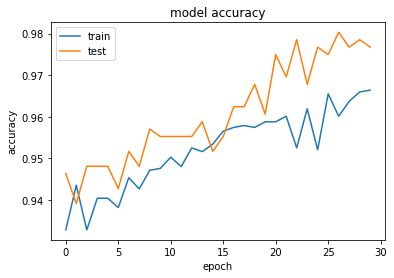

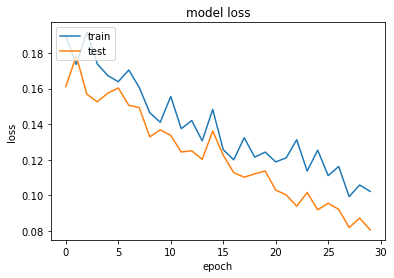

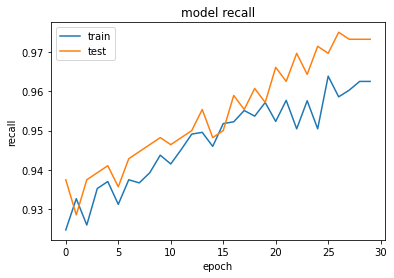

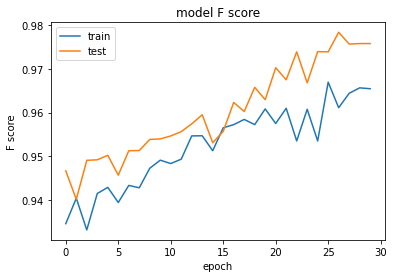

In [47]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model F score')
plt.ylabel('F score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<AxesSubplot:>

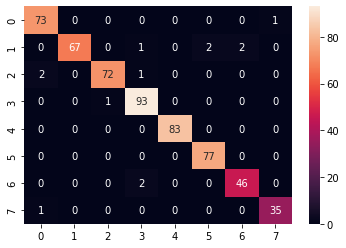

In [44]:
import seaborn as sns
sns.heatmap(cf, annot=True)
